In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import (ImageNormalize, AsinhStretch,
                                    LinearStretch)
import astropy.constants as const
import astropy.units as u
from scipy.io import readsav
import sunpy
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
import irispy
import irispy.io
import cmcrameri.cm as cmcm
from sunkit_image import coalignment
from sun_blinker import SunBlinker

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [4]:
MgII_fitres_file = readsav("../../src/IRIS/20221024/1904/fit_res/MgII_raster0.sav",verbose=True)

--------------------------------------------------
Date: Wed Apr  3 18:04:28 2024
User: yjzhu
Host: NB-RES-YINGJIE
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.8.3
--------------------------------------------------
Successfully read 7 records of which:
 - 4 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - lc [<class 'numpy.ndarray'>]
 - rp [<class 'numpy.ndarray'>]
 - bp [<class 'numpy.ndarray'>]
 - wave_corr_nuv [<class 'numpy.ndarray'>]
--------------------------------------------------


In [45]:
MgII_fitres_file["lc"].shape

(954, 386, 2, 1)

In [5]:
raster_header_MgII = fits.getheader("../../src/IRIS/20221024/1904/iris_l2_20221024_190447_3643101203_raster_t000_r00000.fits",ext=3)

In [8]:
raster_header_MgII

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / Number of bits per data pixel                  
NAXIS   =                    3 / Number of data axes                            
NAXIS1  =                   72 /                                                
NAXIS2  =                  386 /                                                
NAXIS3  =                  954 /                                                
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
BSCALE  =                 0.25 /                                                
BZERO   =                 7992 /                                                
CDELT1  =      0.0509199984372 /                                                
CDELT2  =             0.332700 /                                                
CDELT3  =        0.000000000

In [9]:
iris_1400_sji_1904_cube = irispy.io.read_files("../../src/IRIS/20221024/1904/iris_l2_20221024_190447_3643101203_SJI_1400_t000.fits")

In [26]:
iris_1400_sji_1904_cube.dimensions

<Quantity [477., 386., 364.] pix>

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]


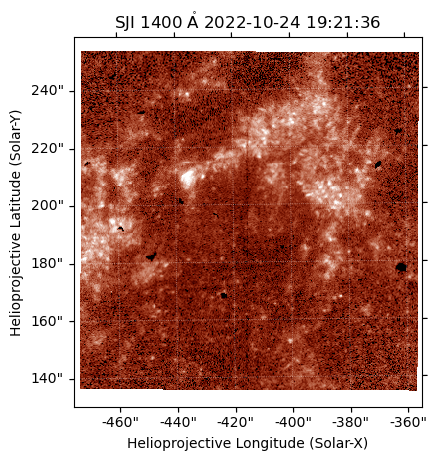

In [28]:
iris_1400_sji_1920_index = 231
iris_1400_sji_1920_map = sunpy.map.Map(iris_1400_sji_1904_cube[iris_1400_sji_1920_index].data,iris_1400_sji_1904_cube[iris_1400_sji_1920_index].meta)
iris_1400_sji_1920_map.meta["date_obs"] = iris_1400_sji_1904_cube[iris_1400_sji_1920_index:iris_1400_sji_1920_index+1].time.value[0]
iris_1400_sji_1920_map.plot_settings['norm'] = ImageNormalize(vmin=0,vmax=20,stretch=AsinhStretch(0.05))
iris_1400_sji_1920_map.plot()

In [29]:
eis_hhflare_195_velmap_shift = sunpy.map.Map('../../src/coalign_map/20221024/eis_hhflare_195_velmap_shift.fits')

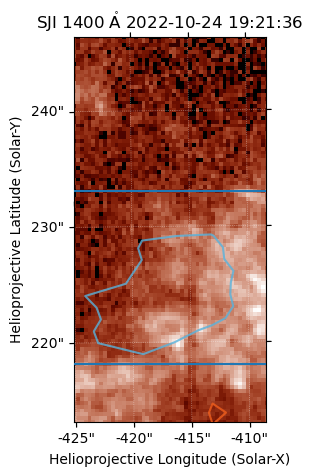

In [44]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111,projection=iris_1400_sji_1920_map)
iris_1400_sji_1920_map.plot(axes=ax)

bounds = ax.axis()
with propagate_with_solar_surface(rotation_model="rigid"):
    cs_hh = eis_hhflare_195_velmap_shift.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],axes=ax,alpha=0.8)
ax.axis(bounds)

ax.set_xlim(150,200)
ax.set_ylim(250,350)
ax.axhline(265)
ax.axhline(310)

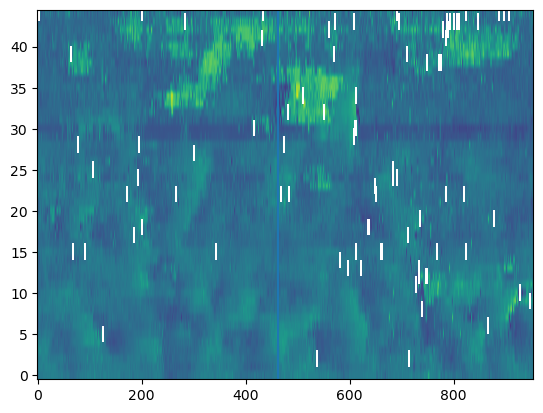

In [48]:
plt.imshow(MgII_fitres_file["lc"][:,265:310,0,0].T,origin="lower",aspect="auto")
plt.axvline(462)

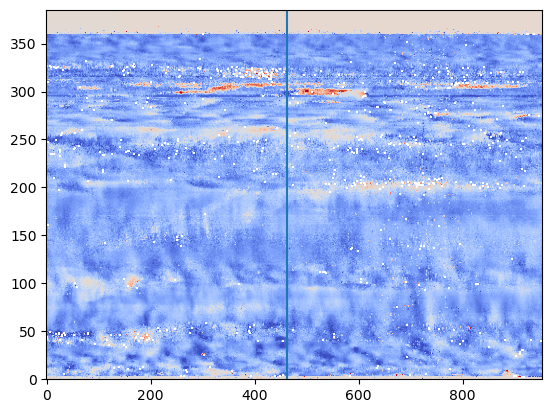

In [53]:
plt.imshow(MgII_fitres_file["lc"][:,:,0,0].T + MgII_fitres_file["wave_corr_nuv"]/2796.351*const.c.to_value(u.km/u.s),origin="lower",aspect="auto",
            vmin=-15,vmax=15,cmap="coolwarm")
plt.axvline(462)

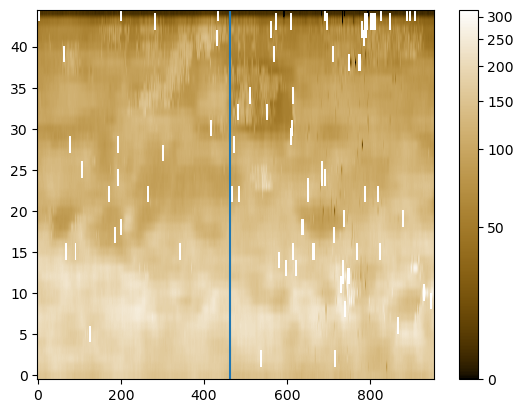

In [60]:
plt.imshow(MgII_fitres_file["lc"][:,265:310,1,0].T,origin="lower",aspect="auto",cmap="irissji2796",
norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.1)))
plt.colorbar()
plt.axvline(462)

In [31]:
raster_MgII_celestial_wcs = WCS(raster_header_MgII).celestial.swapaxes(0,1)
raster_MgII_celestial_header = raster_MgII_celestial_wcs.to_header()
raster_MgII_celestial_header["INSTRUME"] = raster_header_0["INSTRUME"]
raster_MgII_celestial_header["TELESCOP"] = raster_header_0["TELESCOP"]
raster_MgII_celestial_header["DATE_OBS"] = raster_header_0["DATE_OBS"]
raster_MgII_celestial_header["DATE_END"] = raster_header_0["DATE_END"]

In [32]:
MgII_k_mask = None
MgII_h_mask = None

In [33]:
MgII_k_lc_int_map = sunpy.map.Map(MgII_fitres_file["lc"][:,:,1,0].T,raster_MgII_celestial_header,
                                  mask=MgII_k_mask).submap([0,20]*u.pix,top_right=[320,508]*u.pix)
MgII_k_lc_int_map.plot_settings["cmap"] = "irissji2796"
MgII_k_lc_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch(0.1))
MgII_k_lc_int_map.meta["rsun_ref"] = 696000000.0

MgII_k_lc_vel_map = sunpy.map.Map(MgII_fitres_file["lc"][:,:,0,0].T + MgII_fitres_file["wave_corr_nuv"][np.newaxis,:]/2796.351*const.c.to_value(u.km/u.s),
                                  raster_MgII_celestial_header,mask=MgII_k_mask).submap([0,20]*u.pix,top_right=[320,508]*u.pix)
MgII_k_lc_vel_map.plot_settings["cmap"] = "RdBu_r"
MgII_k_lc_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-15,vmax=15)
MgII_k_lc_vel_map.meta["rsun_ref"] = 696000000.0

MgII_k_bp_int_map = sunpy.map.Map(MgII_fitres_file["bp"][:,:,1,0].T,raster_MgII_celestial_header,
                                    mask=MgII_k_mask).submap([0,20]*u.pix,top_right=[320,508]*u.pix)
MgII_k_bp_int_map.plot_settings["cmap"] = "irissji2796"
MgII_k_bp_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch(0.1))
MgII_k_bp_int_map.meta["rsun_ref"] = 696000000.0

MgII_k_bp_vel_map = sunpy.map.Map(MgII_fitres_file["bp"][:,:,0,0].T + MgII_fitres_file["wave_corr_nuv"][np.newaxis,:]/2796.351*const.c.to_value(u.km/u.s),
                                    raster_MgII_celestial_header,mask=MgII_k_mask).submap([0,20]*u.pix,top_right=[320,508]*u.pix)
MgII_k_bp_vel_map.plot_settings["cmap"] = "RdBu_r"
MgII_k_bp_vel_map.plot_settings["norm"] = ImageNormalize(vmin=-30,vmax=0)
MgII_k_bp_vel_map.meta["rsun_ref"] = 696000000.0

MgII_k_rp_int_map = sunpy.map.Map(MgII_fitres_file["rp"][:,:,1,0].T,raster_MgII_celestial_header,
                                    mask=MgII_k_mask).submap([0,20]*u.pix,top_right=[320,508]*u.pix)
MgII_k_rp_int_map.plot_settings["cmap"] = "irissji2796"
MgII_k_rp_int_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=2e3,stretch=AsinhStretch(0.1))
MgII_k_rp_int_map.meta["rsun_ref"] = 696000000.0

MgII_k_rp_vel_map = sunpy.map.Map(MgII_fitres_file["rp"][:,:,0,0].T + MgII_fitres_file["wave_corr_nuv"][np.newaxis,:]/2796.351*const.c.to_value(u.km/u.s),
                                    raster_MgII_celestial_header,mask=MgII_k_mask).submap([0,20]*u.pix,top_right=[320,508]*u.pix)
MgII_k_rp_vel_map.plot_settings["cmap"] = "RdBu_r"
MgII_k_rp_vel_map.plot_settings["norm"] = ImageNormalize(vmin=0,vmax=30)
MgII_k_rp_vel_map.meta["rsun_ref"] = 696000000.0

MgII_k_k2_ratio_map = sunpy.map.Map((MgII_k_bp_int_map.data - MgII_k_rp_int_map.data)/(MgII_k_bp_int_map.data + MgII_k_rp_int_map.data),
                                    MgII_k_bp_int_map.meta,mask=MgII_k_mask)
MgII_k_k2_ratio_map.plot_settings["cmap"] = cmcm.bam
MgII_k_k2_ratio_map.plot_settings["norm"] = ImageNormalize(vmin=-1,vmax=1,stretch=LinearStretch(slope=0.5, intercept=0.5) + AsinhStretch(0.3) + \
    LinearStretch(slope=2, intercept=-1))
MgII_k_k2_ratio_map.meta["rsun_ref"] = 696000000.0

MgII_k_k2_sep_map = sunpy.map.Map(MgII_k_rp_vel_map.data - MgII_k_bp_vel_map.data,
                                MgII_k_rp_vel_map.meta,mask=MgII_k_mask)
MgII_k_k2_sep_map.plot_settings["cmap"] = cmcm.davos
MgII_k_k2_sep_map.plot_settings["norm"] = ImageNormalize(vmin=5,vmax=45)
MgII_k_k2_sep_map.meta["rsun_ref"] = 696000000.0
